In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import datetime
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import timm
import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import PIL
from PIL import Image as image

from Dataloader import dataloader, SquarePad, load_split_train_vaild, setseed
from utils import reshape, drawimg, tensor_to_pltimg, multidrawimg
from utils_traintest import train, test

In [2]:
# Training Device Setting
setseed(42)
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


### Dataloader

In [3]:
data_path = './trainvalid'
# Check data shape
os.getcwd()
image = PIL.Image.open(f"{data_path}/0/0021.jpg")
width, height = image.size
print(width, height)

2880 2136


In [61]:
with open('mobileNetV2.pkl', 'rb') as f:
	mobileNetV2 = pkl.load(f)
with open('densenet201_29647720.pkl', 'rb') as f:
	densenet201 = pkl.load(f)
with open('ResNext50.pkl', 'rb') as f:
	ResNext50 = pkl.load(f)
 

mobileNetV2_t = mobileNetV2.loc[:,['Training Loss','Training Accuracy', 'Seeds']]
mobileNetV2_v = mobileNetV2.loc[:,['Validation Loss','Validation Accuracy', 'Seeds']]
mobileNetV2_t = mobileNetV2_t.rename(columns={'Training Loss':'loss', 'Training Accuracy': 'accuracy'})
mobileNetV2_v = mobileNetV2_v.rename(columns={'Validation Loss':'loss', 'Validation Accuracy': 'accuracy'})
mobileNetV2_t['lable'] = 'train'
mobileNetV2_v['lable'] = 'valid'
mobileNetV2 = pd.concat([mobileNetV2_t,mobileNetV2_v], axis=0)
mobileNetV2.reset_index(inplace=True)
mobileNetV2 = mobileNetV2.rename(columns={'Seeds':'seed', 'lable':'label','index': 'epoch'})
mobileNetV2['model'] = 'mobileNetV2'
mobileNetV2['accuracy'] = mobileNetV2['accuracy']*100

densenet201 = densenet201.drop(labels='index', axis=1)
densenet201 = densenet201.rename(columns={'lable':'label'})
densenet201['model'] = 'densenet201'

ResNext50 = ResNext50.rename(columns={'Seed':'seed'})
ResNext50 = ResNext50.reset_index(drop=True)
ResNext50['model'] = 'ResNext50'
ResNext50['accuracy'] = ResNext50['accuracy']*100

totalresult = pd.DataFrame()
totalresult = pd.concat([mobileNetV2,densenet201], axis=0)
totalresult = pd.concat([totalresult,ResNext50], axis=0)
totalresult = totalresult.reset_index(drop=True)


In [62]:
totalresult

,epoch,loss,accuracy,seed,label,model
0,0,5.445502,40.509014,0,train,mobileNetV2
1,1,2.637773,54.400848,0,train,mobileNetV2
2,2,1.113842,53.022269,0,train,mobileNetV2
3,3,0.814311,55.673383,0,train,mobileNetV2
4,4,0.754848,59.172853,0,train,mobileNetV2
...,...,...,...,...,...,...
1095,15,1.369896,55.048611,9,train,ResNext50
1096,16,1.372453,55.944444,9,train,ResNext50
1097,17,1.370437,55.451389,9,train,ResNext50
1098,18,1.372874,54.326389,9,train,ResNext50


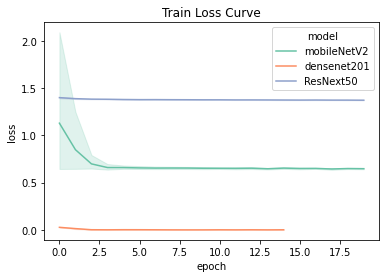

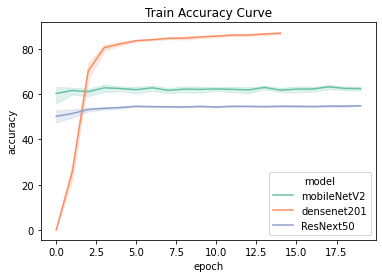

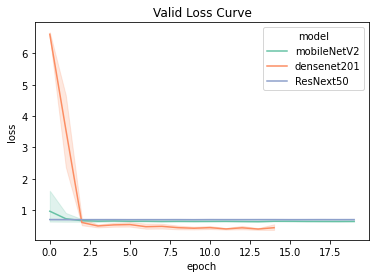

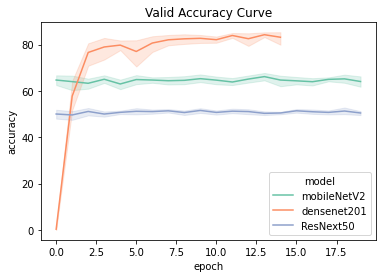

In [65]:
plt.title('Train Loss Curve')
sns.lineplot(data=totalresult[totalresult['label']=='train'],x='epoch',y='loss',hue='model',palette="Set2")
plt.show()
plt.title('Train Accuracy Curve')
sns.lineplot(data=totalresult[totalresult['label']=='train'],x='epoch',y='accuracy',hue='model',palette="Set2")
plt.show()
plt.title('Valid Loss Curve')
sns.lineplot(data=totalresult[totalresult['label']=='valid'],x='epoch',y='loss',hue='model',palette="Set2")
plt.show()
plt.title('Valid Accuracy Curve')
sns.lineplot(data=totalresult[totalresult['label']=='valid'],x='epoch',y='accuracy',hue='model',palette="Set2")
plt.show()

In [4]:
#DataLoad
data_path = './trainvalid/'
train_transforms = transforms.Compose([SquarePad(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(), 
                                       ])
trainl, validl= load_split_train_vaild(data_path, train_transforms, valid_size=.2, batch_size=4)

943 236 1179 1179


torch.Size([3, 224, 224])


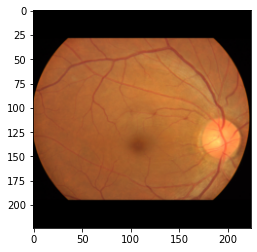

236

In [5]:
print(trainl.dataset[10][0].size())
plt.imshow(np.uint8(trainl.dataset[0][0].permute(1,2,0)*255))
plt.show()
len(validl.dataset)

In [6]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [7]:
mname = 'densenet201'
model = timm.create_model(mname)
params = sum(p.numel() for p in model.parameters())
epochs = 15
total_df = pd.DataFrame()
seedlist = [*range(10)]

In [42]:

for seed in seedlist:
    setseed(seed)
    mname = 'densenet201'
    model = timm.create_model(mname)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=224, stride=2, padding=3, bias=False)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
    params = sum(p.numel() for p in model.parameters())
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        traindf = train(trainl, model, loss_fn, optimizer,device=device, epoch=int(t), seed=seed)
        validdf = test(validl, model, loss_fn, device=device, epoch=int(t), seed=seed)
        total_df = pd.concat([total_df, traindf])
        total_df = pd.concat([total_df, validdf])
    
    torch.save(model.state_dict(), f"{mname}_{params}_{seed}.pth")
    print("Saved PyTorch Model State to model.pth")


total_df = total_df.reset_index()
total_df.to_pickle("{mname}_{params}_{seed}.pkl")  

Epoch 1
-------------------------------
loss: 7.032288  [    0/  943]
loss: 6.907118  [  400/  943]
loss: 6.700417  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.777642 

Epoch 2
-------------------------------
loss: 6.593505  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 5.878583  [  400/  943]
loss: 5.196019  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 50.8%, Avg loss: 4.795102 

Epoch 3
-------------------------------
loss: 5.150058  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.770777  [  400/  943]
loss: 0.227431  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.505594 

Epoch 4
-------------------------------
loss: 0.391158  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.739579  [  400/  943]
loss: 0.363145  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.420018 

Epoch 5
-------------------------------
loss: 1.139956  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.389523  [  400/  943]
loss: 0.959954  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.803050 

Epoch 6
-------------------------------
loss: 0.529195  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.660707  [  400/  943]
loss: 0.182598  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.467663 

Epoch 7
-------------------------------
loss: 0.358101  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.531536  [  400/  943]
loss: 0.429862  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.486924 

Epoch 8
-------------------------------
loss: 0.531759  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.824407  [  400/  943]
loss: 0.484035  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.368286 

Epoch 9
-------------------------------
loss: 0.220368  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.137407  [  400/  943]
loss: 0.736520  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.2%, Avg loss: 0.355455 

Epoch 10
-------------------------------
loss: 0.165511  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.060783  [  400/  943]
loss: 0.146676  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.6%, Avg loss: 0.374380 

Epoch 11
-------------------------------
loss: 0.219436  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.268968  [  400/  943]
loss: 0.467133  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.534324 

Epoch 12
-------------------------------
loss: 0.469116  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.270066  [  400/  943]
loss: 0.614762  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 77.1%, Avg loss: 0.468485 

Epoch 13
-------------------------------
loss: 0.201338  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.504737  [  400/  943]
loss: 0.731871  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.8%, Avg loss: 0.493143 

Epoch 14
-------------------------------
loss: 0.601874  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.277978  [  400/  943]
loss: 0.505628  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.399098 

Epoch 15
-------------------------------
loss: 0.133778  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.718935  [  400/  943]
loss: 0.039165  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 86.9%, Avg loss: 0.362242 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 6.846221  [    0/  943]
loss: 6.723536  [  400/  943]
loss: 6.588572  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.514171 

Epoch 2
-------------------------------
loss: 6.490011  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.304208  [  400/  943]
loss: 5.306905  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 65.7%, Avg loss: 4.370031 

Epoch 3
-------------------------------
loss: 5.092120  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.464279  [  400/  943]
loss: 1.351361  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 78.4%, Avg loss: 0.537241 

Epoch 4
-------------------------------
loss: 0.100431  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.409106  [  400/  943]
loss: 0.165120  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.436773 

Epoch 5
-------------------------------
loss: 0.275706  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.012633  [  400/  943]
loss: 0.451491  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 72.9%, Avg loss: 0.643578 

Epoch 6
-------------------------------
loss: 0.319472  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.778219  [  400/  943]
loss: 0.620411  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.430938 

Epoch 7
-------------------------------
loss: 0.355965  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.401882  [  400/  943]
loss: 0.072210  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.430915 

Epoch 8
-------------------------------
loss: 0.386457  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.405746  [  400/  943]
loss: 1.078723  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.387787 

Epoch 9
-------------------------------
loss: 0.235633  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.469115  [  400/  943]
loss: 0.419744  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.6%, Avg loss: 0.382074 

Epoch 10
-------------------------------
loss: 0.259100  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.125324  [  400/  943]
loss: 0.397220  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 86.0%, Avg loss: 0.384725 

Epoch 11
-------------------------------
loss: 0.485251  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.263084  [  400/  943]
loss: 0.293977  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.2%, Avg loss: 0.381735 

Epoch 12
-------------------------------
loss: 0.399137  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.146474  [  400/  943]
loss: 0.122262  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.389916 

Epoch 13
-------------------------------
loss: 0.271535  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.025672  [  400/  943]
loss: 0.456708  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.6%, Avg loss: 0.387775 

Epoch 14
-------------------------------
loss: 0.043694  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.217223  [  400/  943]
loss: 0.140279  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.373080 

Epoch 15
-------------------------------
loss: 0.088469  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.418890  [  400/  943]
loss: 0.261043  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.6%, Avg loss: 0.383286 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 6.855399  [    0/  943]
loss: 6.767523  [  400/  943]
loss: 6.527952  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.8%, Avg loss: 6.502735 

Epoch 2
-------------------------------
loss: 6.607176  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.087730  [  400/  943]
loss: 5.589041  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 49.2%, Avg loss: 3.621457 

Epoch 3
-------------------------------
loss: 4.243371  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.700693  [  400/  943]
loss: 0.439898  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.501323 

Epoch 4
-------------------------------
loss: 0.288787  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.342848  [  400/  943]
loss: 0.489247  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.5%, Avg loss: 0.494005 

Epoch 5
-------------------------------
loss: 0.121572  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.239603  [  400/  943]
loss: 0.650556  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 78.0%, Avg loss: 0.478111 

Epoch 6
-------------------------------
loss: 0.163760  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.617844  [  400/  943]
loss: 0.772374  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 86.4%, Avg loss: 0.402799 

Epoch 7
-------------------------------
loss: 0.115690  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.249247  [  400/  943]
loss: 0.233896  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 64.0%, Avg loss: 0.897878 

Epoch 8
-------------------------------
loss: 0.034694  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.227105  [  400/  943]
loss: 0.232613  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.553191 

Epoch 9
-------------------------------
loss: 0.258012  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.419152  [  400/  943]
loss: 0.249733  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.388684 

Epoch 10
-------------------------------
loss: 0.217580  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.074417  [  400/  943]
loss: 0.132102  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.446990 

Epoch 11
-------------------------------
loss: 0.855159  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.301010  [  400/  943]
loss: 0.590689  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 77.5%, Avg loss: 0.615149 

Epoch 12
-------------------------------
loss: 0.244883  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.249322  [  400/  943]
loss: 0.245329  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.5%, Avg loss: 0.390310 

Epoch 13
-------------------------------
loss: 0.197982  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.235038  [  400/  943]
loss: 0.070891  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 79.7%, Avg loss: 0.535115 

Epoch 14
-------------------------------
loss: 0.188507  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.746614  [  400/  943]
loss: 0.138135  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.488428 

Epoch 15
-------------------------------
loss: 0.181220  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.312715  [  400/  943]
loss: 0.499820  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.370140 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 6.882755  [    0/  943]
loss: 6.734453  [  400/  943]
loss: 6.719471  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.604664 

Epoch 2
-------------------------------
loss: 6.573625  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 5.955499  [  400/  943]
loss: 0.397828  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 74.6%, Avg loss: 0.595771 

Epoch 3
-------------------------------
loss: 0.435901  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.202764  [  400/  943]
loss: 1.374061  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.475336 

Epoch 4
-------------------------------
loss: 0.320656  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.117558  [  400/  943]
loss: 0.427235  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.444359 

Epoch 5
-------------------------------
loss: 0.342977  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.891738  [  400/  943]
loss: 0.253464  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.9%, Avg loss: 0.491089 

Epoch 6
-------------------------------
loss: 0.219700  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.395476  [  400/  943]
loss: 0.355494  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.414821 

Epoch 7
-------------------------------
loss: 0.160363  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.045454  [  400/  943]
loss: 0.327880  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 72.9%, Avg loss: 0.528902 

Epoch 8
-------------------------------
loss: 0.368439  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.116245  [  400/  943]
loss: 0.240745  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 79.2%, Avg loss: 0.524097 

Epoch 9
-------------------------------
loss: 1.440556  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.297914  [  400/  943]
loss: 0.534908  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.436365 

Epoch 10
-------------------------------
loss: 0.101781  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.137430  [  400/  943]
loss: 0.476534  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.398062 

Epoch 11
-------------------------------
loss: 0.272641  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.178132  [  400/  943]
loss: 0.243761  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.376683 

Epoch 12
-------------------------------
loss: 0.169351  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.249026  [  400/  943]
loss: 0.229888  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.372810 

Epoch 13
-------------------------------
loss: 0.213766  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.082751  [  400/  943]
loss: 0.142698  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.368589 

Epoch 14
-------------------------------
loss: 0.495910  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.460440  [  400/  943]
loss: 0.126816  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.357105 

Epoch 15
-------------------------------
loss: 0.172478  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.431916  [  400/  943]
loss: 0.755491  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.429608 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 7.055276  [    0/  943]
loss: 6.924626  [  400/  943]
loss: 6.798414  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.703531 

Epoch 2
-------------------------------
loss: 6.734796  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.464158  [  400/  943]
loss: 6.151193  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 48.7%, Avg loss: 5.879790 

Epoch 3
-------------------------------
loss: 5.490722  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 4.845589  [  400/  943]
loss: 0.677161  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 79.7%, Avg loss: 0.628749 

Epoch 4
-------------------------------
loss: 0.310236  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.557801  [  400/  943]
loss: 0.346123  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 77.5%, Avg loss: 0.502892 

Epoch 5
-------------------------------
loss: 0.800962  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.783563  [  400/  943]
loss: 0.952092  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.531695 

Epoch 6
-------------------------------
loss: 0.815313  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.565410  [  400/  943]
loss: 0.294770  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.478809 

Epoch 7
-------------------------------
loss: 0.236868  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.078066  [  400/  943]
loss: 0.156513  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.415633 

Epoch 8
-------------------------------
loss: 0.401930  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.260583  [  400/  943]
loss: 0.766295  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.516049 

Epoch 9
-------------------------------
loss: 0.707788  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.664143  [  400/  943]
loss: 0.616077  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 77.5%, Avg loss: 0.580274 

Epoch 10
-------------------------------
loss: 0.040005  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.133836  [  400/  943]
loss: 0.962925  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.6%, Avg loss: 0.376501 

Epoch 11
-------------------------------
loss: 0.153687  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.703813  [  400/  943]
loss: 0.317531  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.374054 

Epoch 12
-------------------------------
loss: 0.478995  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.080597  [  400/  943]
loss: 0.038585  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.369501 

Epoch 13
-------------------------------
loss: 0.802402  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.116680  [  400/  943]
loss: 1.401606  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 63.6%, Avg loss: 0.643423 

Epoch 14
-------------------------------
loss: 0.440920  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.574863  [  400/  943]
loss: 0.082796  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 86.0%, Avg loss: 0.358906 

Epoch 15
-------------------------------
loss: 0.459292  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.139777  [  400/  943]
loss: 0.755895  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 86.9%, Avg loss: 0.347113 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 7.039870  [    0/  943]
loss: 6.835322  [  400/  943]
loss: 6.792863  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.642535 

Epoch 2
-------------------------------
loss: 6.700961  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.220094  [  400/  943]
loss: 2.014237  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 63.6%, Avg loss: 0.905403 

Epoch 3
-------------------------------
loss: 1.036299  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.861234  [  400/  943]
loss: 0.144460  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 75.4%, Avg loss: 0.632702 

Epoch 4
-------------------------------
loss: 1.354936  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.309702  [  400/  943]
loss: 0.335141  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.2%, Avg loss: 0.474240 

Epoch 5
-------------------------------
loss: 0.776185  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.527303  [  400/  943]
loss: 0.441041  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.462703 

Epoch 6
-------------------------------
loss: 0.597829  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.190612  [  400/  943]
loss: 0.433043  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 58.5%, Avg loss: 0.776851 

Epoch 7
-------------------------------
loss: 0.811846  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.424385  [  400/  943]
loss: 0.275056  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.417773 

Epoch 8
-------------------------------
loss: 0.278223  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.581186  [  400/  943]
loss: 0.063715  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.412555 

Epoch 9
-------------------------------
loss: 0.120630  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.657998  [  400/  943]
loss: 1.023690  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.416987 

Epoch 10
-------------------------------
loss: 0.115141  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.224119  [  400/  943]
loss: 0.168954  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 72.0%, Avg loss: 0.792516 

Epoch 11
-------------------------------
loss: 0.101409  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.063908  [  400/  943]
loss: 0.913729  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 77.5%, Avg loss: 0.546897 

Epoch 12
-------------------------------
loss: 0.119950  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.117374  [  400/  943]
loss: 0.075513  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.387668 

Epoch 13
-------------------------------
loss: 0.284227  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.337491  [  400/  943]
loss: 0.044518  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.372031 

Epoch 14
-------------------------------
loss: 0.138633  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.773708  [  400/  943]
loss: 0.099355  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.5%, Avg loss: 0.383056 

Epoch 15
-------------------------------
loss: 0.134040  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.060635  [  400/  943]
loss: 0.094522  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.2%, Avg loss: 0.372234 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 6.932044  [    0/  943]
loss: 6.749101  [  400/  943]
loss: 6.664434  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.527868 

Epoch 2
-------------------------------
loss: 6.564151  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.047725  [  400/  943]
loss: 1.053742  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 59.7%, Avg loss: 1.062212 

Epoch 3
-------------------------------
loss: 0.655888  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.143697  [  400/  943]
loss: 0.412660  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 55.1%, Avg loss: 0.976690 

Epoch 4
-------------------------------
loss: 1.212087  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.198552  [  400/  943]
loss: 0.773814  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 79.2%, Avg loss: 0.541764 

Epoch 5
-------------------------------
loss: 1.596873  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.382206  [  400/  943]
loss: 0.347511  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.5%, Avg loss: 0.426015 

Epoch 6
-------------------------------
loss: 0.549939  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.634420  [  400/  943]
loss: 0.082103  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.505779 

Epoch 7
-------------------------------
loss: 0.082240  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.152414  [  400/  943]
loss: 0.135324  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.385266 

Epoch 8
-------------------------------
loss: 0.066802  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.583854  [  400/  943]
loss: 0.306902  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.400472 

Epoch 9
-------------------------------
loss: 0.309929  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.165806  [  400/  943]
loss: 0.079410  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.503393 

Epoch 10
-------------------------------
loss: 0.192792  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.354102  [  400/  943]
loss: 0.079380  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 76.7%, Avg loss: 0.535491 

Epoch 11
-------------------------------
loss: 0.882163  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.443420  [  400/  943]
loss: 0.129388  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.459796 

Epoch 12
-------------------------------
loss: 0.140176  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.253693  [  400/  943]
loss: 0.288281  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.394162 

Epoch 13
-------------------------------
loss: 0.594148  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.419457  [  400/  943]
loss: 0.526785  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.447561 

Epoch 14
-------------------------------
loss: 0.083819  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.681279  [  400/  943]
loss: 0.060611  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 86.4%, Avg loss: 0.382090 

Epoch 15
-------------------------------
loss: 0.123288  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.095452  [  400/  943]
loss: 0.031485  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.367641 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 7.180074  [    0/  943]
loss: 6.925271  [  400/  943]
loss: 6.711473  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.750243 

Epoch 2
-------------------------------
loss: 6.799941  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.232526  [  400/  943]
loss: 5.761644  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 57.2%, Avg loss: 5.507967 

Epoch 3
-------------------------------
loss: 5.571181  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 2.091412  [  400/  943]
loss: 0.687223  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.529599 

Epoch 4
-------------------------------
loss: 0.342733  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.912528  [  400/  943]
loss: 0.508982  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.435004 

Epoch 5
-------------------------------
loss: 0.285519  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.499652  [  400/  943]
loss: 0.906255  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.443437 

Epoch 6
-------------------------------
loss: 1.141142  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.569261  [  400/  943]
loss: 0.132525  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.452754 

Epoch 7
-------------------------------
loss: 0.425539  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.043585  [  400/  943]
loss: 0.138633  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.361077 

Epoch 8
-------------------------------
loss: 0.912057  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.870478  [  400/  943]
loss: 0.043507  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 81.8%, Avg loss: 0.396307 

Epoch 9
-------------------------------
loss: 0.103490  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.319654  [  400/  943]
loss: 0.155550  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.355519 

Epoch 10
-------------------------------
loss: 0.357566  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.181463  [  400/  943]
loss: 0.793327  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.363797 

Epoch 11
-------------------------------
loss: 0.130311  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.241399  [  400/  943]
loss: 0.119053  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.390570 

Epoch 12
-------------------------------
loss: 0.006284  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.215466  [  400/  943]
loss: 0.049796  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.372645 

Epoch 13
-------------------------------
loss: 0.067919  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.104941  [  400/  943]
loss: 0.217373  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.359820 

Epoch 14
-------------------------------
loss: 0.062318  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.056590  [  400/  943]
loss: 0.161898  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.384918 

Epoch 15
-------------------------------
loss: 0.060470  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.258132  [  400/  943]
loss: 0.493519  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 85.6%, Avg loss: 0.351317 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 6.846269  [    0/  943]
loss: 6.683532  [  400/  943]
loss: 6.459156  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 1.7%, Avg loss: 6.438428 

Epoch 2
-------------------------------
loss: 6.441215  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.140423  [  400/  943]
loss: 5.794159  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 51.3%, Avg loss: 5.643900 

Epoch 3
-------------------------------
loss: 5.777757  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.830515  [  400/  943]
loss: 1.072305  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 71.2%, Avg loss: 0.776092 

Epoch 4
-------------------------------
loss: 0.654605  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.682262  [  400/  943]
loss: 0.179952  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 66.9%, Avg loss: 0.581949 

Epoch 5
-------------------------------
loss: 0.687487  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.861429  [  400/  943]
loss: 0.384441  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.454415 

Epoch 6
-------------------------------
loss: 0.194539  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.817361  [  400/  943]
loss: 0.976042  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 75.8%, Avg loss: 0.679966 

Epoch 7
-------------------------------
loss: 0.376217  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.161587  [  400/  943]
loss: 0.495863  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.431443 

Epoch 8
-------------------------------
loss: 0.741398  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.257722  [  400/  943]
loss: 0.147067  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.770630 

Epoch 9
-------------------------------
loss: 0.600657  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.108465  [  400/  943]
loss: 0.071836  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.3%, Avg loss: 0.385910 

Epoch 10
-------------------------------
loss: 0.220977  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.078218  [  400/  943]
loss: 0.347922  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.414749 

Epoch 11
-------------------------------
loss: 0.085835  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.067332  [  400/  943]
loss: 0.657147  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.434138 

Epoch 12
-------------------------------
loss: 0.195559  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.157335  [  400/  943]
loss: 0.189560  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.535032 

Epoch 13
-------------------------------
loss: 0.088626  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.420352  [  400/  943]
loss: 0.044001  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.398350 

Epoch 14
-------------------------------
loss: 0.303250  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.592358  [  400/  943]
loss: 0.469030  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.401091 

Epoch 15
-------------------------------
loss: 0.050899  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.765530  [  400/  943]
loss: 0.192351  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.418621 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Epoch 1
-------------------------------
loss: 7.100514  [    0/  943]
loss: 6.842900  [  400/  943]
loss: 6.778508  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 0.0%, Avg loss: 6.676855 

Epoch 2
-------------------------------
loss: 6.606425  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 6.292147  [  400/  943]
loss: 5.587115  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 49.2%, Avg loss: 4.022101 

Epoch 3
-------------------------------
loss: 3.948504  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 1.331040  [  400/  943]
loss: 0.560240  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 79.2%, Avg loss: 0.606645 

Epoch 4
-------------------------------
loss: 0.131222  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.215551  [  400/  943]
loss: 0.258028  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 69.9%, Avg loss: 0.580692 

Epoch 5
-------------------------------
loss: 0.056636  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.025840  [  400/  943]
loss: 0.723447  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 79.2%, Avg loss: 0.516764 

Epoch 6
-------------------------------
loss: 0.466783  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.185989  [  400/  943]
loss: 0.508077  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 59.7%, Avg loss: 0.784946 

Epoch 7
-------------------------------
loss: 1.562973  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.085318  [  400/  943]
loss: 0.575238  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.423517 

Epoch 8
-------------------------------
loss: 0.080114  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.386594  [  400/  943]
loss: 0.422979  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.501491 

Epoch 9
-------------------------------
loss: 0.273455  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.126041  [  400/  943]
loss: 0.083443  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.5%, Avg loss: 0.479739 

Epoch 10
-------------------------------
loss: 0.323120  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.711398  [  400/  943]
loss: 0.305511  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.5%, Avg loss: 0.387191 

Epoch 11
-------------------------------
loss: 0.173928  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.315818  [  400/  943]
loss: 0.042398  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.375195 

Epoch 12
-------------------------------
loss: 0.504829  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.364859  [  400/  943]
loss: 0.165566  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 83.9%, Avg loss: 0.380607 

Epoch 13
-------------------------------
loss: 0.176520  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.865172  [  400/  943]
loss: 0.021066  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 84.7%, Avg loss: 0.358552 

Epoch 14
-------------------------------
loss: 0.068956  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.205181  [  400/  943]
loss: 0.023834  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 80.9%, Avg loss: 0.481215 

Epoch 15
-------------------------------
loss: 0.545652  [    0/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


loss: 0.101868  [  400/  943]
loss: 0.355490  [  800/  943]


c:\Users\user\code\AdvancedNN\utils_traintest.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


Test Error: 
 Accuracy: 70.8%, Avg loss: 0.891976 

Saved PyTorch Model State to model.pth


c:\Users\user\code\AdvancedNN\utils_traintest.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(current, ignore_index = True)


In [15]:
total_df = pd.read_pickle("{mname}_{params}_{seed}.pkl")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

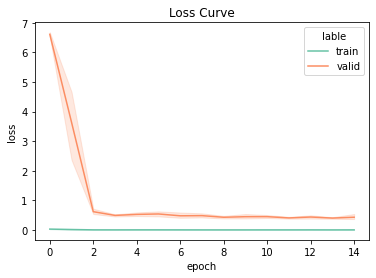

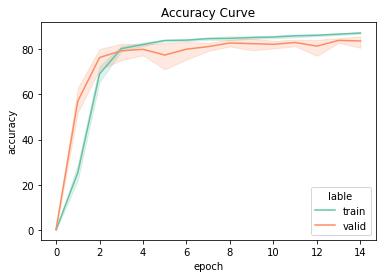

In [46]:
plt.title('Loss Curve')
sns.lineplot(data=total_df,x='epoch',y='loss',hue='lable',palette="Set2")
plt.show()
plt.title('Accuracy Curve')
sns.lineplot(data=total_df,x='epoch',y='accuracy',hue='lable',palette="Set2")
plt.show()

### Test

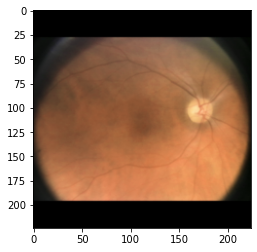

In [41]:
datadir_test_1 = "./test_1/"
datadir_test_2 = "./test_2/"
datadir_test_3 = "./test_3/"
   
params= 29647720  

test_transforms_1 = transforms.Compose([SquarePad(),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])
test_transforms_2 = transforms.Compose([SquarePad(),
                                        transforms.CenterCrop(1350),
                                        transforms.Resize(224),
                                        transforms.ToTensor(), 
                                        ])
test_transforms_3 = transforms.Compose([SquarePad(),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=(0.05,0.1)),
                                        ])
    

test_data_1 = datasets.ImageFolder(datadir_test_1,transform=test_transforms_1)
test_data_2 = datasets.ImageFolder(datadir_test_2,transform=test_transforms_2)
test_data_3 = datasets.ImageFolder(datadir_test_3,transform=test_transforms_3)

totaldata = test_data_1+test_data_2+test_data_3
    # Prepare MNIST dataset by concatenating Train/Test part; we split later.
testloader = torch.utils.data.DataLoader(totaldata, batch_size=1, shuffle=False)
# print(testloader.dataset[0][1])
plt.imshow(np.uint8(testloader.dataset[60][0].permute(1,2,0)*255))
plt.show()

result_list = list()


for seed in seedlist:
    model = timm.create_model(mname)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=224, stride=2, padding=3, bias=False)
    model.load_state_dict(torch.load(f'{mname}_{params}_{seed}.pth'))
    model.eval()
    for data, y in testloader:
        
        # again no gradients needed
        with torch.no_grad():
            model.to(device)
            data = data.to(device).float()
            pred = model(data)
            prediction = pred.argmax().item()
            result = {'seed': seed, 'lable': prediction}

        result_list.append(result)

df_result = pd.DataFrame(result_list)
df_result.to_excel(f"{mname}_{params}.xlsx")


### GradCam

In [96]:
import cv2
import argparse
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import models, transforms
from torchvision.io.image import read_image
import torchcam
from torchcam.utils import overlay_mask
from torchcam.methods import GradCAM, SmoothGradCAMpp
from torchvision.transforms.functional import normalize, resize, to_pil_image

import pandas as pd 
from pandas import ExcelWriter

In [74]:
datapath = './gradcamimg/'
datalist = []
for root, dirs, files in os.walk(datapath):
    for f in files:
        path = os.path.join(datapath,f)
        datalist.append(path)
        print(path)

./gradcamimg/0001.jpg
./gradcamimg/0008.jpg
./gradcamimg/20051020_43906_0100_PP.png
./gradcamimg/20051020_44598_0100_PP.png
./gradcamimg/214808544484087_1637569673316_RIGHT_4.jpg
./gradcamimg/214808545107675_1638192792770_LEFT_4.jpg


['./gradcamimg/0001.jpg',
 './gradcamimg/0008.jpg',
 './gradcamimg/20051020_43906_0100_PP.png',
 './gradcamimg/20051020_44598_0100_PP.png',
 './gradcamimg/214808544484087_1637569673316_RIGHT_4.jpg',
 './gradcamimg/214808545107675_1638192792770_LEFT_4.jpg']

In [86]:
def cal_iou(img, map):
    """calculate intersection over union

    Parameters
    ----------
    img : PIL.PngImagePlugin.PngImageFile
        pillow image
    map : numpy.ndarray
        feature importance map
    label : numpy.ndarray
        sementic segmentation label
    """
    result = torchcam.utils.overlay_mask(img, 
                        transforms.functional.to_pil_image(map, mode='F'), 
                        alpha=0.5
                        )

    trans = transforms.ToPILImage()
    map = trans(map)
    map = np.array(map.resize((img.width, img.height)))
    pred = np.where(map > 255*0.6, True, False)


    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

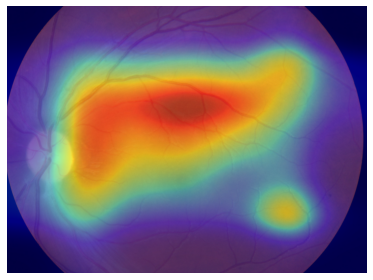

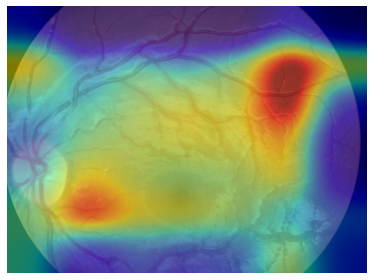

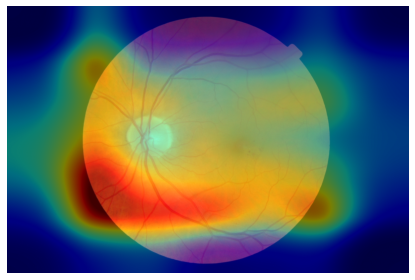

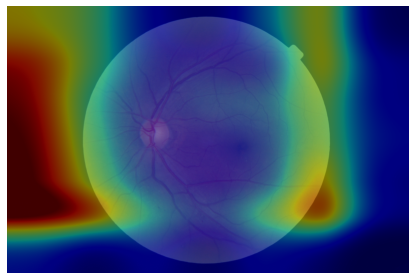

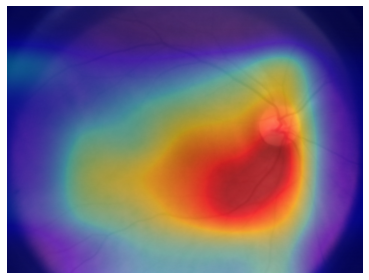

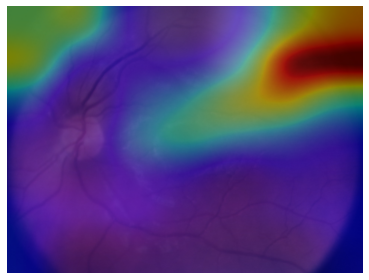

In [134]:
for path in datalist:
    model = timm.create_model(mname)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=224, stride=2, padding=3, bias=False)
    model.eval()
    img = read_image(path)
    input = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # cam = GradCAM(model, target_layer='features')
    cam = GradCAM(model)
    
    # Preprocess your data and feed it to the model
    out = model(input.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

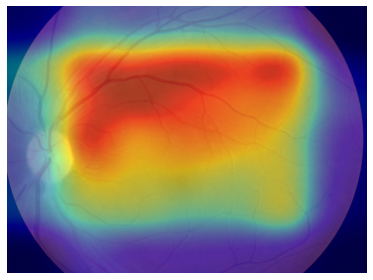

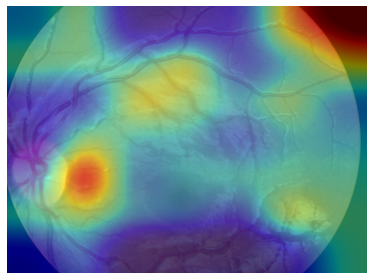

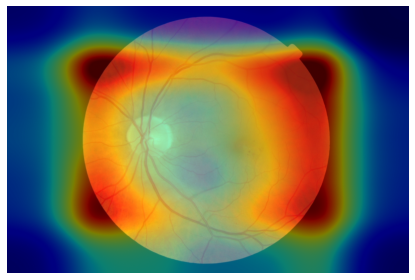

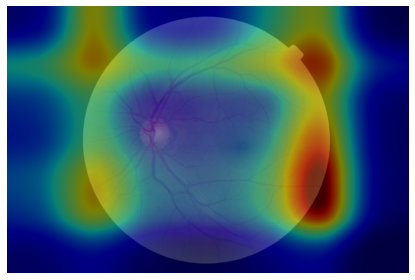

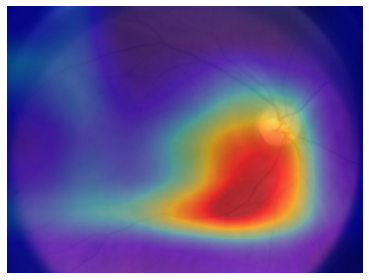

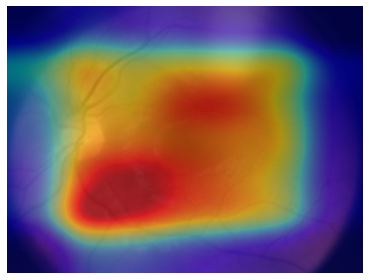

In [133]:
for path in datalist:
    model = timm.create_model(mname)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=224, stride=2, padding=3, bias=False)
    model.eval()
    img = read_image(path)
    input = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # cam = GradCAM(model, target_layer='features')
    cam = GradCAM(model)
    
    # Preprocess your data and feed it to the model
    out = model(input.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()


In [135]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [131]:
dir(timm.create_model('resnet10t'))

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_ver